# Capstone Project: Audio Classification of cats and dogs

## Abstract
In this capstone project I will develop a classification model that processes audio files containing maowing cats and barking dogs. I choose this task since audio files are transformed to images (called **Mel Spectograms**) and those images are then processed the 'normal way' with a convolution neural network, which I found very interesting.

The data set containing 277 audio files can be downloaded from Kaggle: https://www.kaggle.com/mmoreaux/audio-cats-and-dogs.

I followed some of the algortithms published in the following article series by [Ketan Doshi](https://ketanhdoshi.medium.com/): 

https://towardsdatascience.com/audio-deep-learning-made-simple-part-1-state-of-the-art-techniques-da1d3dff2504

A good desription of Mel spectograms can be found here:

https://medium.com/analytics-vidhya/understanding-the-mel-spectrogram-fca2afa2ce53

In [1]:
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

## Data Analysis
The dataset contains ".wav" files for both the *'cat'* and *'dog'* classes:

- 'cat' has 164 WAV files with in total 1323 sec of audio
- 'dog' has 113 WAV files with in total 598 sec of audio

When using sound or image files there is probably less data analysis to be done than in the case of data sets with many variables. As we will see lateron the size of the images generated from the sound files depends on 2 factors:

- Audio length: the width of the image depends on the length of the audio file
- Mel bins: the height of the image depends on the number of the so called *Mel bins* (partitions of the frequency scale)

Since we want to generate images with the same dimension, we need to have the same values for all audio files. The number of Mel bins is a parameter and therefore fixed for all files but the lengths of the audio files differ.

So the first task is to analyze to which audio length all audio files should be converted. Audio files that are longer than this common length will be truncated. For audio files that are shorter, we have 2 options to extend them:

- by adding zeroes (silence) at the end or beginning of the audio file
- by repeating the content until the required length is reached

In this case I favour the second solution since barking/maowing is a repetitive sound and we do not change its contents very much by repeating it (which would be a different case when processing human speech :>)).

### Loading the Audio Files
The audios are loaded and processed using the 'librosa' python library.

In [2]:
import os
import glob

import numpy as np  # linear algebra
import pandas as pd

import librosa
import librosa.display

from IPython.display import Audio

import matplotlib.pyplot as plt
import seaborn as sns

seed = 2022
np.random.seed(seed)

In [3]:
ROOT_DIR = './dataset/cats_dogs'

def load_audio_file(type, label, file):
    data, sample_rate = librosa.load(file)
    data, _ = librosa.effects.trim(data) # trim silent edges
    audio_length_sec = librosa.get_duration(y=data, sr=sample_rate)
    return type, label, file, data, sample_rate, audio_length_sec

In [4]:
audio = load_audio_file('train', 'cat', './dataset/cats_dogs/train/cat/cat_1.wav')
audio

('train',
 'cat',
 './dataset/cats_dogs/train/cat/cat_1.wav',
 array([ 0.00381674,  0.00407222,  0.00156718, ..., -0.0146927 ,
        -0.01779636, -0.01206966], dtype=float32),
 22050,
 11.2)

In [5]:
Audio(audio[3], rate=audio[4])

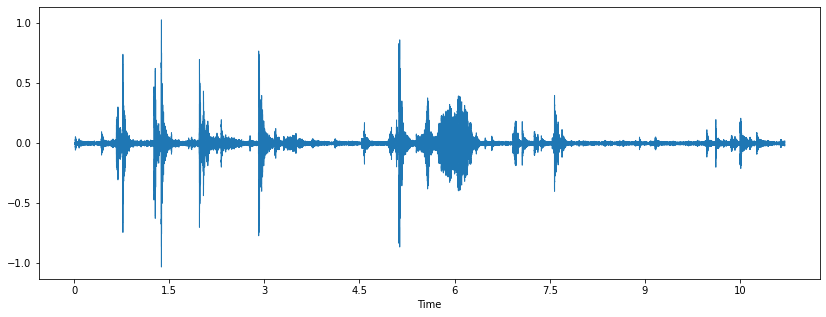

In [6]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio[3], sr=audio[4])

In [7]:
def load_audio_files():
    audios = []
    for type in ['train', 'test']:
        for label in ['cat', 'dog']:
            for file in glob.glob(f'{ROOT_DIR}/{type}/{label}/*.wav'):
                audios.append(load_audio_file(type, label, file))
    return pd.DataFrame(audios, columns=['type', 'label', 'file', 'audio', 'sample_rate', 'duration'])

In [8]:
df = load_audio_files()
df.head()

,type,label,file,audio,sample_rate,duration
0,train,cat,./dataset/cats_dogs/train/cat/cat_74.wav,"[-0.0072117224, -0.0073498413, -0.004983032, -...",22050,6.200000
1,train,cat,./dataset/cats_dogs/train/cat/cat_60.wav,"[7.2517065e-07, -4.9697384e-05, 1.1448158e-05,...",22050,13.511156
2,train,cat,./dataset/cats_dogs/train/cat/cat_48.wav,"[-0.36809683, -0.2285297, 0.0877735, 0.2568504...",22050,11.800000
3,train,cat,./dataset/cats_dogs/train/cat/cat_132.wav,"[0.0076420866, 0.00998313, 0.009568622, 0.0091...",22050,15.192018
4,train,cat,./dataset/cats_dogs/train/cat/cat_127.wav,"[-0.00021272199, -0.0011838893, -0.002049844, ...",22050,10.500000


### Analyzing the (Duration of the) Audio Files
To find a good value for the audio length I check the distribution:

In [9]:
df.duration.describe()

count    277.000000
mean       6.933430
std        4.586837
min        0.876916
25%        2.593605
50%        5.896417
75%       11.800000
max       17.929569
Name: duration, dtype: float64

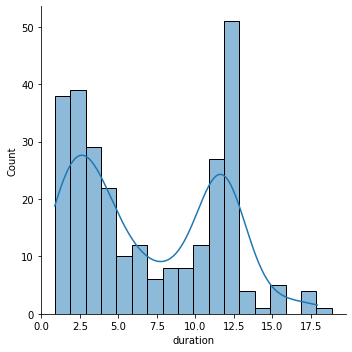

In [10]:
sns.displot(df, x="duration", binwidth=1, kde=True)

This is disappointing! I had hoped to see a normal distribution meaning that most audios have more or less the same length but we seem to have many audios with a length < 6 seconds and a second cluster with audio length between 10 and 12 seconds.

When we check the distribution for each category, we get the following:

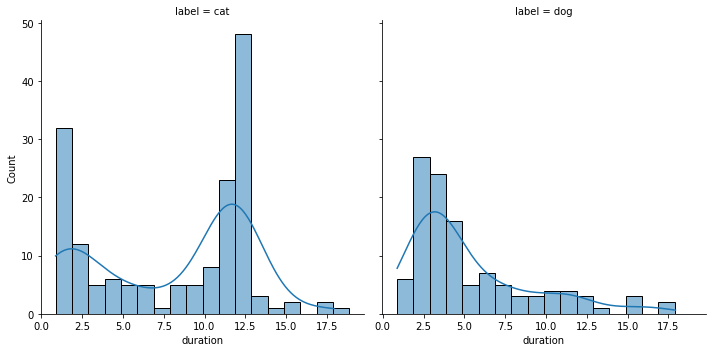

In [11]:
sns.displot(df, x="duration", col="label", binwidth=1, kde=True)

I decided to go for 7 seconds as a first try. When tuning the model later, I might try some other length as well. 

## Data Preparation
### Resizing all audios to the same length

In [12]:
req_duration = 7

def resize_audio(audio, sample_rate, duration):
    max_length = int(duration * sample_rate)
    while len(audio) < max_length:
        audio = np.concatenate([audio, audio])
        
    if len(audio) > max_length:    
        audio = audio[:max_length] # truncate the audio

    return audio

In [13]:
too_short_audio = df[df['duration'] < 5].iloc[0]
resized_audio = resize_audio(too_short_audio['audio'], too_short_audio['sample_rate'], req_duration)
Audio(resized_audio, rate=too_short_audio['sample_rate'])

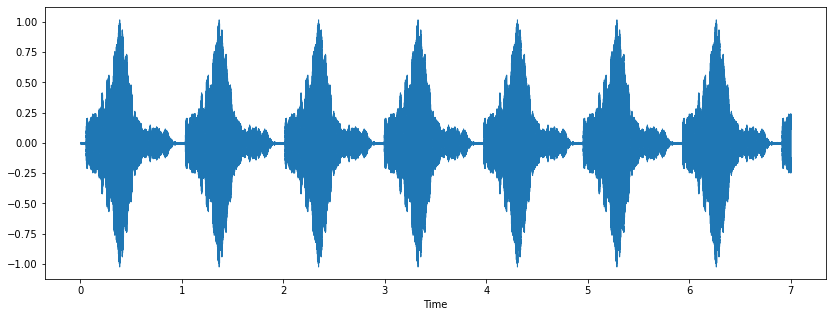

In [14]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(resized_audio, sr=too_short_audio['sample_rate'])

In [15]:
too_long_audio = df[df['duration'] > 10].iloc[0]
resized_audio = resize_audio(too_long_audio['audio'], too_long_audio['sample_rate'], req_duration)
Audio(resized_audio, rate=too_long_audio['sample_rate'])

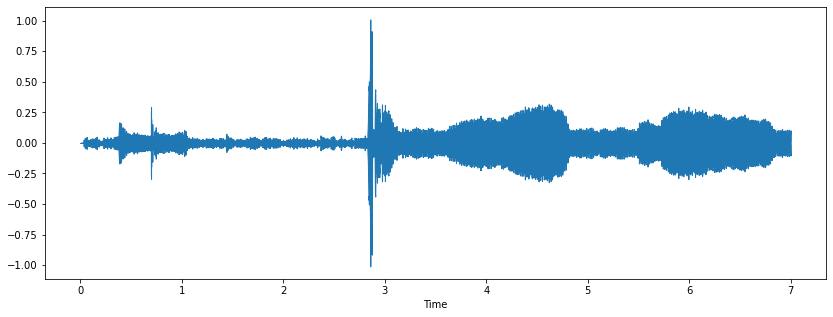

In [16]:
plt.figure(figsize=(14, 5))
librosa.display.waveshow(resized_audio, sr=too_short_audio['sample_rate'])

In [17]:
df['resized_duration'] = req_duration
df['resized_audio'] = df.apply(lambda x: resize_audio(x['audio'], x['sample_rate'], req_duration), axis=1)
df.head()

,type,label,file,audio,sample_rate,duration,resized_duration,resized_audio
0,train,cat,./dataset/cats_dogs/train/cat/cat_74.wav,"[-0.0072117224, -0.0073498413, -0.004983032, -...",22050,6.200000,7,"[-0.0072117224, -0.0073498413, -0.004983032, -..."
1,train,cat,./dataset/cats_dogs/train/cat/cat_60.wav,"[7.2517065e-07, -4.9697384e-05, 1.1448158e-05,...",22050,13.511156,7,"[7.2517065e-07, -4.9697384e-05, 1.1448158e-05,..."
2,train,cat,./dataset/cats_dogs/train/cat/cat_48.wav,"[-0.36809683, -0.2285297, 0.0877735, 0.2568504...",22050,11.800000,7,"[-0.36809683, -0.2285297, 0.0877735, 0.2568504..."
3,train,cat,./dataset/cats_dogs/train/cat/cat_132.wav,"[0.0076420866, 0.00998313, 0.009568622, 0.0091...",22050,15.192018,7,"[0.0076420866, 0.00998313, 0.009568622, 0.0091..."
4,train,cat,./dataset/cats_dogs/train/cat/cat_127.wav,"[-0.00021272199, -0.0011838893, -0.002049844, ...",22050,10.500000,7,"[-0.00021272199, -0.0011838893, -0.002049844, ..."


In [18]:
print("Number of 'cat' training audios: {}".format(len(df[(df['type'] == 'train') & (df['label'] == 'cat')])))
print("Number of 'dog' training audios: {}".format(len(df[(df['type'] == 'train') & (df['label'] == 'dog')])))
print("Number of 'cat' test audios: {}".format(len(df[(df['type'] == 'test') & (df['label'] == 'cat')])))
print("Number of 'dog' test audios: {}".format(len(df[(df['type'] == 'test') & (df['label'] == 'dog')])))

Number of 'cat' training audios: 125
Number of 'dog' training audios: 85
Number of 'cat' test audios: 39
Number of 'dog' test audios: 28


### Augmenting the Audio Files
Like images audio files also can be augmented, not by rotating, sketching or flipping them but one can perform the following transformations:

- Noise injection: modify the noise slightly
- Time shift: moving the waves to the right/left
- Time stretch: stretch or shorten the waves making the sound go slower or faster
- Pitch shift: make the amplitude of the wave a bit higher or lower

For each transformation I will plotthe waveform of the resulting audio to show the difference that was made.
This is the original waveform:

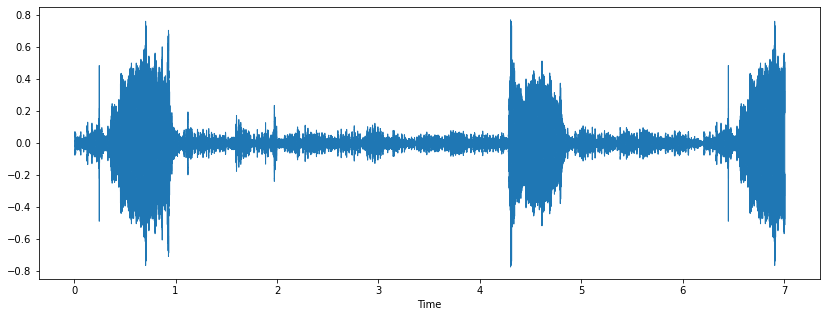

In [19]:
audio = df.iloc(0)[0]
plt.figure(figsize=(14, 5))
librosa.display.waveshow(audio['resized_audio'], sr=audio['sample_rate'])

#### Noise Injection

In [20]:
def noise_injection(audio, sample_rate, noise_factor=.01):
    noise = np.random.randn(len(audio))
    ni = audio + noise * noise_factor
    return ni

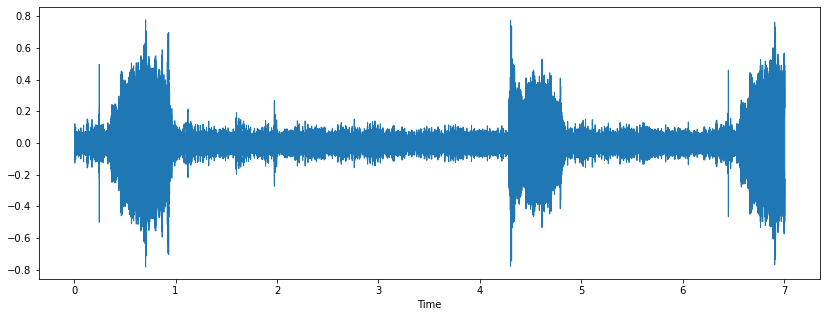

In [21]:
ni_audio = noise_injection(audio['resized_audio'], audio['sample_rate'], noise_factor=.02)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(ni_audio, sr=audio['sample_rate'])

In [22]:
Audio(ni_audio, rate=audio['sample_rate'])

#### Time Shift

In [23]:
def time_shift(audio, sample_rate, shift_rate=.5):
    shift = int(sample_rate * shift_rate) # lenght of sample rate is 1 second
    ts = np.roll(audio, shift)
    return ts

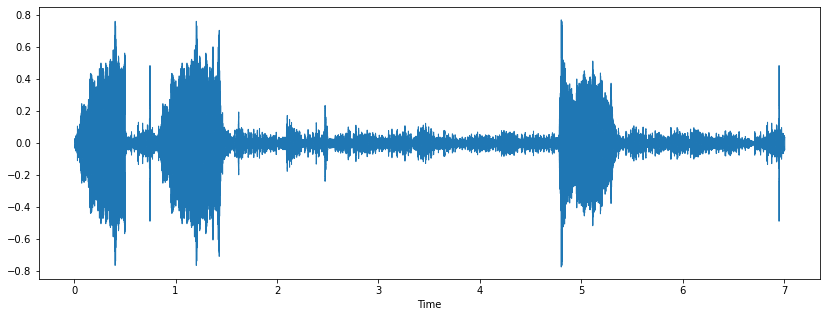

In [24]:
ts_audio = time_shift(audio['resized_audio'], audio['sample_rate'])
plt.figure(figsize=(14, 5))
librosa.display.waveshow(ts_audio, sr=audio['sample_rate'])

In [25]:
Audio(ts_audio, rate=audio['sample_rate'])

#### Time Stretch

In [26]:
def time_stretch(audio, sample_rate, duration, stretch_rate=.25):
    audio_length = len(audio)
    stretch = 1 + np.random.randint(-100*stretch_rate, 100*stretch_rate) / 100
    ts = librosa.effects.time_stretch(audio, stretch)
    return resize_audio(ts, sample_rate, duration)

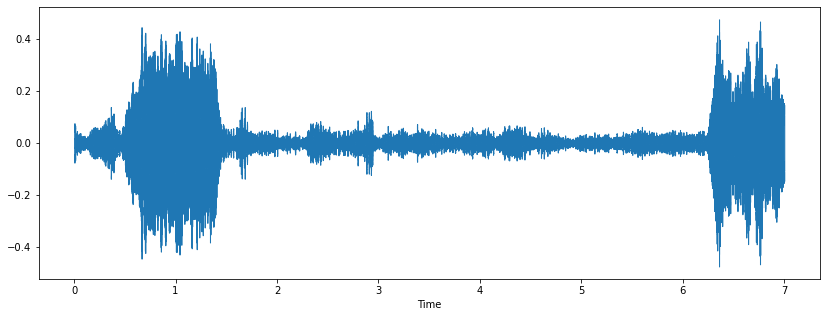

In [27]:
ts_audio = time_stretch(audio['resized_audio'], audio['sample_rate'], audio['resized_duration'], stretch_rate=.5)
plt.figure(figsize=(14, 5))
librosa.display.waveshow(ts_audio, sr=audio['sample_rate'])

In [28]:
Audio(ts_audio, rate=audio['sample_rate'])

#### Pitch Shift

In [29]:
def pitch_shift(audio_signals, sample_rate, max_steps=4):
    n_steps = np.random.randint(-max_steps, max_steps)
    ps = librosa.effects.pitch_shift(audio_signals, sample_rate, n_steps=n_steps)
    return ps

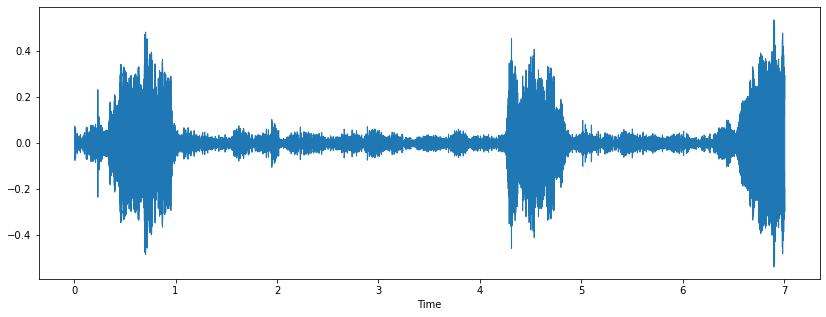

In [30]:
ps_audio = pitch_shift(audio['resized_audio'], audio['sample_rate'])
plt.figure(figsize=(14, 5))
librosa.display.waveshow(ps_audio, sr=audio['sample_rate'])

In [31]:
Audio(ps_audio, rate=audio['sample_rate'])

#### Putting it all together
Now that we have some transformations that we can apply to the audio files, I will generate some more training data by augmenting every training audio by 2 transformations that are selected randomly:

In [32]:
def augment_audio(audio):
    aug = np.random.randint(0, 4)
    augmented_audio = audio
    if aug == 0:
        augmented_audio = noise_injection(audio['resized_audio'], audio['sample_rate'])
    if aug == 1:
        augmented_audio = time_shift(audio['resized_audio'], audio['sample_rate'])
    if aug == 2:
        augmented_audio = time_stretch(audio['resized_audio'], audio['sample_rate'], audio['resized_duration'])
    if aug == 3:
        augmented_audio = pitch_shift(audio['resized_audio'], audio['sample_rate'])
    return augmented_audio

def augment_audio_df(df):
    res = df.copy()
    for index, audio in df[df['type'] == 'train'].iterrows():
        new_audio = audio.copy()
        new_audio['resized_audio'] = augment_audio(audio);
        res = res.append(new_audio)

    return res

In [ ]:
aug_df = augment_audio_df(augment_audio_df(df)) # augment twice
print("New number of 'cat' training audios: {}".format(len(aug_df[(aug_df['type'] == 'train') & (aug_df['label'] == 'cat')])))
print("New number of 'dog' training audios: {}".format(len(aug_df[(aug_df['type'] == 'train') & (aug_df['label'] == 'dog')])))

### Generating Mel Spectograms
The following parameters can be set when generating Mel Spectograms:
##### Frequency Bands
- **fmin** the minimum frequency
- **fmax** the maximum frequency to display
- **n_mels** the number of frequency bands (ie. Mel bins). This is the height of the Spectrogram

##### Time Sections
- **n_fft** the window length for each time section
- **hop_length** the number of samples by which to slide the window at each step. 

Hence, the width of the Spectrogram is = Total number of samples / hop_length

**Note:** I have not documented it in this notebook but I have tried several values for these parameters but did not find any relevant differences for the accuracies of the predictions lateron so I sticked with the default values.

In [ ]:
n_mels=128
n_fft=2048
hop_length=512

def create_mel_spectogram(audio, sample_rate, n_mels, n_fft, hop_length):
    sgram = librosa.stft(audio)
    mel_scale_sgram = librosa.feature.melspectrogram(S=librosa.magphase(sgram)[0], 
                                                     sr=sample_rate,
                                                     n_mels=n_mels,
                                                     n_fft=n_fft, 
                                                     hop_length=hop_length)
    return librosa.amplitude_to_db(mel_scale_sgram, ref=np.min)

def plot_mel_spectogram(sp, sr):
    plt.figure(figsize=(14, 5))
    librosa.display.specshow(sp, sr=sr, x_axis='time', y_axis='mel')
    plt.colorbar(format='%+2.0f dB')

In [ ]:
audio = aug_df.iloc(0)[0]
mel_sgram = create_mel_spectogram(audio['resized_audio'], audio['sample_rate'], 
                                  n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
plot_mel_spectogram(mel_sgram, audio['sample_rate'])

In [ ]:
def create_mel_spectogram_df(df, n_mels, n_fft, hop_length):
    res = df.copy()
    res['mel_sgram'] = res.apply(lambda x: create_mel_spectogram(x['resized_audio'], x['sample_rate'], 
                                                                 n_mels=n_mels, 
                                                                 n_fft=n_fft, 
                                                                 hop_length=hop_length), axis=1)
    return res

In [ ]:
final_df = create_mel_spectogram_df(aug_df, n_mels, n_fft, hop_length)
final_df.head()

#### Augmenting Mel Spectograms
Not only the audios but also the Mel Spectograms can be augmented by blocking out sections. One can block out a range of frequencies by adding horizontal bars (frequency masking) on the spectogram and block out a time range by using vertical bars (time masking). 

**Note:** I decided not to mask the specto grams since I will drop out nodes of the CNN when training the network.

### Saving the Audio Images

In [ ]:
import skimage.io

IMG_DIR = './dataset/images'

def scale_minmax(X, min=0.0, max=1.0):
    X_std = (X - X.min()) / (X.max() - X.min())
    X_scaled = X_std * (max - min) + min
    return X_scaled

def save_mel_spectogram_image(mel_sgram, file):
    img = scale_minmax(mel_sgram, 0, 255).astype(np.uint8)
    img = np.flip(img, axis=0) # put low frequencies at the bottom in image
    img = 255 - img # invert. make black==more energy

    # save as PNG
    skimage.io.imsave(file, img)
    
def save_mel_spectogram_images_df(df):
    for type in ['train', 'test']:
        for label in ['cat', 'dog']:
            dirName = f"{IMG_DIR}/{type}/{label}"
            if not os.path.exists(dirName):
                os.makedirs(dirName)
            
    for index, audio in df.iterrows():
        file = f"{IMG_DIR}/{audio['type']}/{audio['label']}/{audio['label']}_{index}.png"
        save_mel_spectogram_image(audio['mel_sgram'], file)

In [ ]:
save_mel_spectogram_images_df(final_df)

## ML Model

In [ ]:
import tensorflow as tf
import tensorflow_io as tfio
from tensorflow import keras

### Loading the Train and Test Datasets

In [ ]:
def load_mel_spectogram_images(img_width, img_height):
    train_directory = './dataset/images/train'
    test_directory = './dataset/images/test'
    
    train_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_directory, labels='inferred', label_mode='int', image_size=(img_height, img_width), 
        validation_split=0.2, subset='training', seed=seed)

    val_ds = tf.keras.preprocessing.image_dataset_from_directory(
        train_directory, labels='inferred', label_mode='int', image_size=(img_height, img_width), 
        validation_split=0.2, subset='validation', seed=seed)

    test_ds = tf.keras.preprocessing.image_dataset_from_directory(
        test_directory, labels='inferred', label_mode='int', image_size=(img_height, img_width), 
        validation_split=None, subset=None)
    
    return train_ds, val_ds, test_ds

def show_mel_spectogram_images(ds, num=9):
    class_names = ds.class_names

    plt.figure(figsize=(10, 10))
    for images, labels in ds.take(1):
        for i in range(num):
            ax = plt.subplot(3, 3, i+1)
            plt.imshow(images[i].numpy().astype("uint8"))
            plt.title(class_names[labels[i]])
            plt.axis("off")

In [ ]:
img_width = 256
img_height = 256
train_ds, val_ds, test_ds = load_mel_spectogram_images(img_width, img_height)
show_mel_spectogram_images(train_ds)

### Creating the Model

In [ ]:
def create_model(num_classes, learning_rate, img_width, img_height, dropout_rate=0):
    model = tf.keras.Sequential([
        tf.keras.layers.experimental.preprocessing.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
        tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
        tf.keras.layers.MaxPooling2D(),
        tf.keras.layers.Dropout(dropout_rate),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(128, activation='relu'),
        tf.keras.layers.Dense(num_classes)
        ])
        
    loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer, loss_fn, ['accuracy'])

    return model

In [ ]:
num_classes = len(train_ds.class_names)
num_epochs = 10

In [ ]:
learning_rate = 0.001

model = create_model(num_classes, learning_rate, img_width, img_height)
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)

In [ ]:
model.evaluate(test_ds)

### Optimizing the Model
If we analyze the history of the accuracy and loss values we see that there seems to be no overfitting (the differences between training and validation remain small and the development follows a same learning curve). 
I guess this is because we already augmented the audio files...

In [ ]:
def plot_history(history):
    acc = history.history['accuracy']
    val_acc = history.history['val_accuracy']

    loss = history.history['loss']
    val_loss = history.history['val_loss']

    epochs_range = range(num_epochs)

    plt.figure(figsize=(8, 8))
    plt.subplot(1, 2, 1)
    plt.plot(epochs_range, acc, label='Training Accuracy')
    plt.plot(epochs_range, val_acc, label='Validation Accuracy')
    plt.legend(loc='lower right')
    plt.title('Training and Validation Accuracy')

    plt.subplot(1, 2, 2)
    plt.plot(epochs_range, loss, label='Training Loss')
    plt.plot(epochs_range, val_loss, label='Validation Loss')
    plt.legend(loc='upper right')
    plt.title('Training and Validation Loss')
    plt.show()

In [ ]:
plot_history(history)

#### Learning Rate
The default learnng rate (0.001) worked very well but I check some other values:

In [ ]:
learning_rates = [0.001, 0.01, 0.1]

models = []
histories = []
for learning_rate in learning_rates:
    model = create_model(num_classes, learning_rate, img_width, img_height)
    models.append(model)
    print(f"\nFitting with learning rate {learning_rate}")
    history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)
    histories.append(history)

In [ ]:
for model in models:
    model.evaluate(test_ds)

In [ ]:
for history in histories:
    plot_history(history)

The **best** and consistent learning curve is achieved with a **learning rate 0.001**.

In [ ]:
best_learning_rate = 0.001

#### Dropout
Since I decided not to augment the Mel Spectograms, I introduce a dropout regularization to the network.

In [ ]:
dropout_rates = [0.1, 0.2, 0.3, 0.4, 0.5]

models = []
histories = []
for dropout_rate in dropout_rates:
    model = create_model(num_classes, best_learning_rate, img_width, img_height, dropout_rate=dropout_rate)
    models.append(model)
    print(f"\nFitting with dropout rate {dropout_rate}")
    history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds)
    histories.append(history)

In [ ]:
for model in models:
    model.evaluate(test_ds)

In [ ]:
for history in histories:
    plot_history(history)

The **best dropout rate** seems to be **0.1**. 

In [ ]:
best_dropout_rate = 0.1

#### Generating the best Model
Using the best learning and dropout rates I will generate the final 'best' model:

In [ ]:
num_epochs = 20
model = create_model(num_classes, best_learning_rate, img_width, img_height, dropout_rate=best_dropout_rate)
checkpoint = keras.callbacks.ModelCheckpoint(
    "cats_and_dogs_v1_{epoch:02d}_{val_accuracy:.3f}.h5",
    save_best_only=True,
    monitor="val_accuracy"
)
history = model.fit(train_ds, epochs=num_epochs, validation_data=val_ds, callbacks=[checkpoint])

In [ ]:
model.evaluate(test_ds)